In [14]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

from itertools import cycle
from tqdm.auto import trange

from matplotlib import cm
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils import plot as plot_utils
from utils import s3w as s3w_utils
from utils import vmf as vmf_utils
from utils import misc as misc_utils
from utils import vi as vi_utils

from methods import s3wd as s3w, sswd as ssw, swd as sw

from experiments.SWVI import vmf_mixture, power_spherical as power_spherical_utils

from scipy.stats import gaussian_kde

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Acknowledgement: Adapted from Bonet et al. 2023 (https://github.com/clbonet/spherical_sliced-wasserstein)

In [2]:
mu=torch.tensor([[0,1,0]], dtype=torch.float, device=device)
kappa=10
V = lambda x : -torch.log(vmf_utils.pdf_vmf(x, mu, kappa))
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

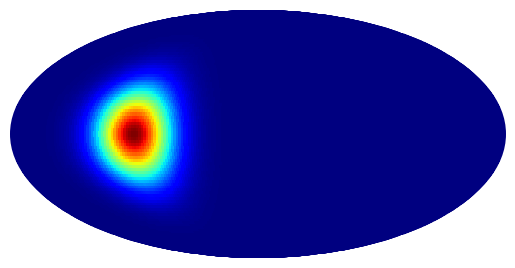

In [3]:
plot_utils.plot_target_density(target)

In [4]:
x, L = vi_utils.ULA_sphere(V, device=device, d=3, n_steps=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

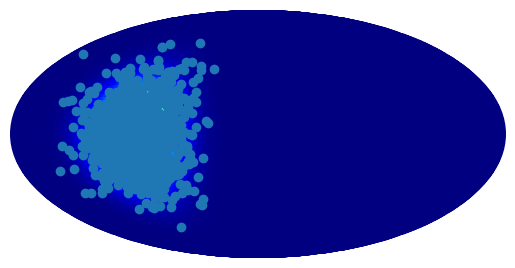

In [5]:
plot_utils.scatter_mollweide(x.detach().cpu(), target)


In [6]:
mu = torch.tensor([0,1,0], dtype=torch.float, device=device)
kappa = torch.tensor(10, device=device)

ps = power_spherical_utils.PowerSpherical(mu, kappa)

V = lambda x : -ps.log_prob(x)
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

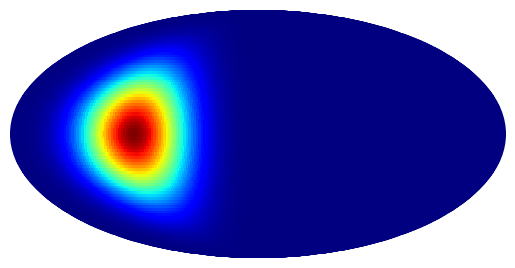

In [7]:
plot_utils.plot_target_density(target)

In [8]:
x, L = vi_utils.ULA_sphere(V, device=device, d=3, n_steps=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

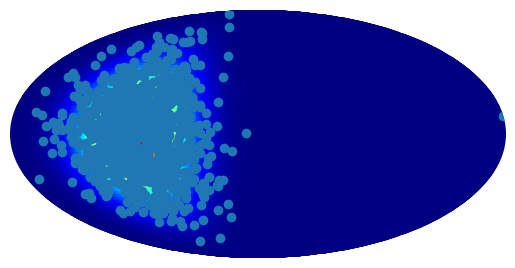

In [9]:
plot_utils.scatter_mollweide(x.detach().cpu(), target)

In [10]:
mu = torch.tensor([0,1,0], dtype=torch.float, device=device)
kappa = torch.tensor(10, device=device)

ps = power_spherical_utils.PowerSpherical(mu, kappa)

V = lambda x : -ps.log_prob(x)
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

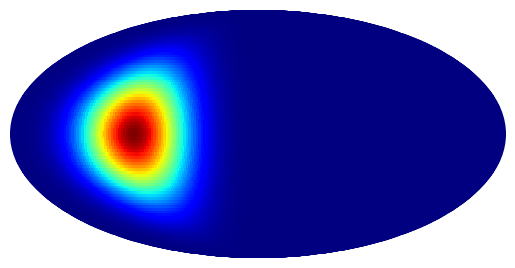

In [11]:
plot_utils.plot_target_density(target)

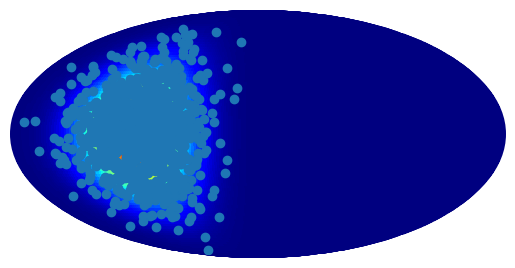

In [12]:
x_ps = ps.sample((1000,))
plot_utils.scatter_mollweide(x_ps.detach().cpu(), target)

In [15]:
d_func = s3w.s3wd 
d_args = {'p': 2, 'n_projs': 1000, 'device': device}
m, k, Lm, Lk, s = power_spherical_utils.run_exp(2001, V, d_func=d_func, device=device, d_args=d_args, d=3, n_particles=500, snapshot_t=[0,500,1000,1500,2000])

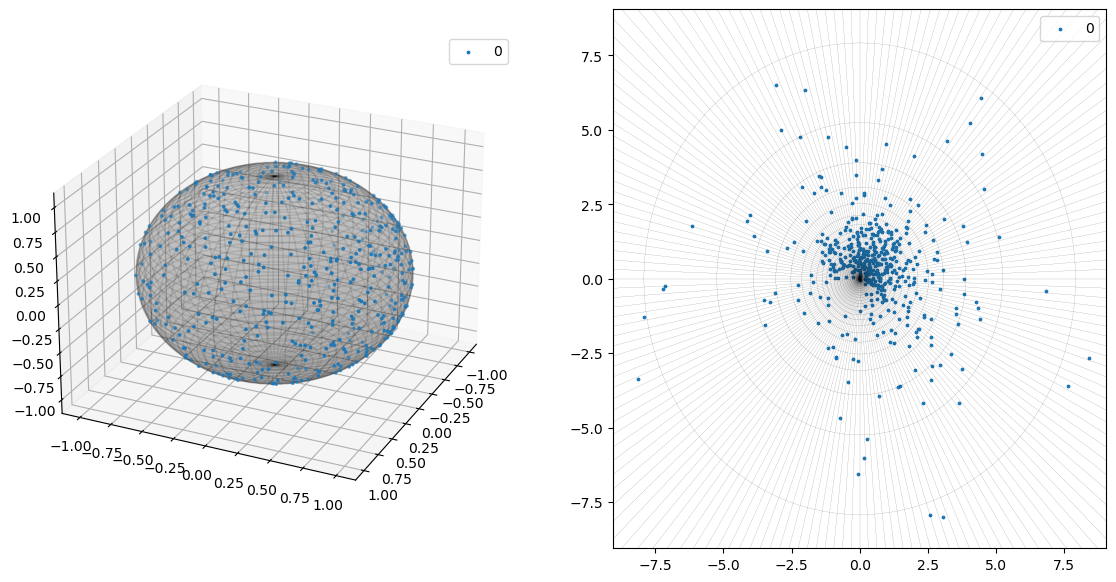

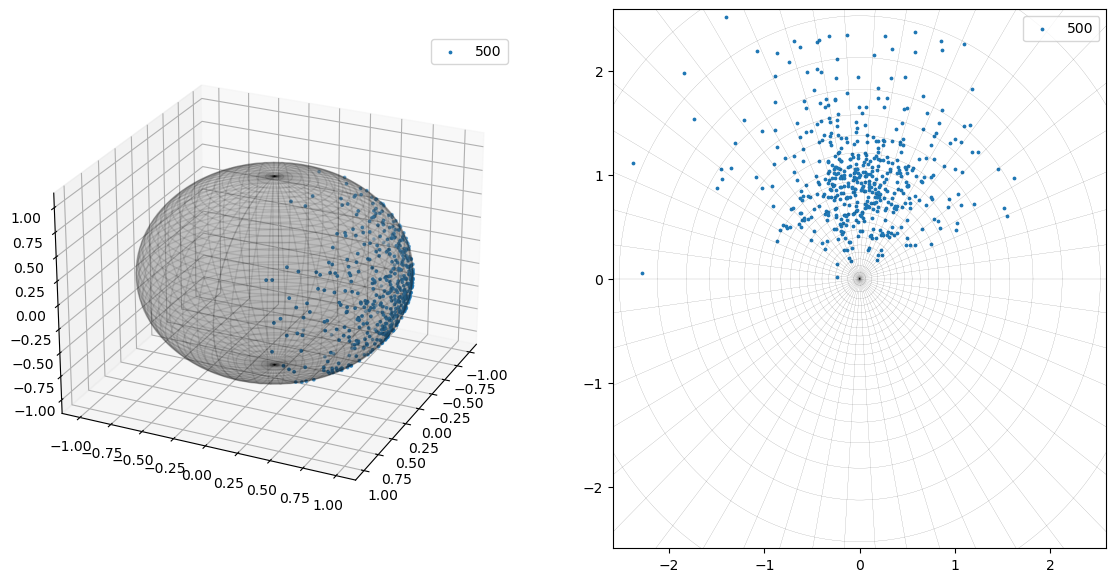

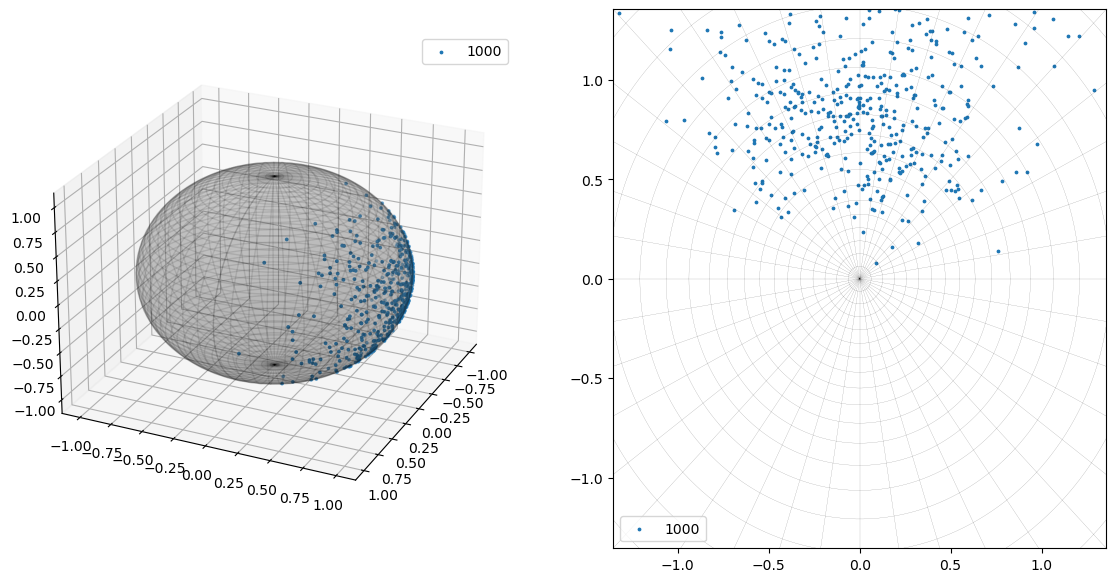

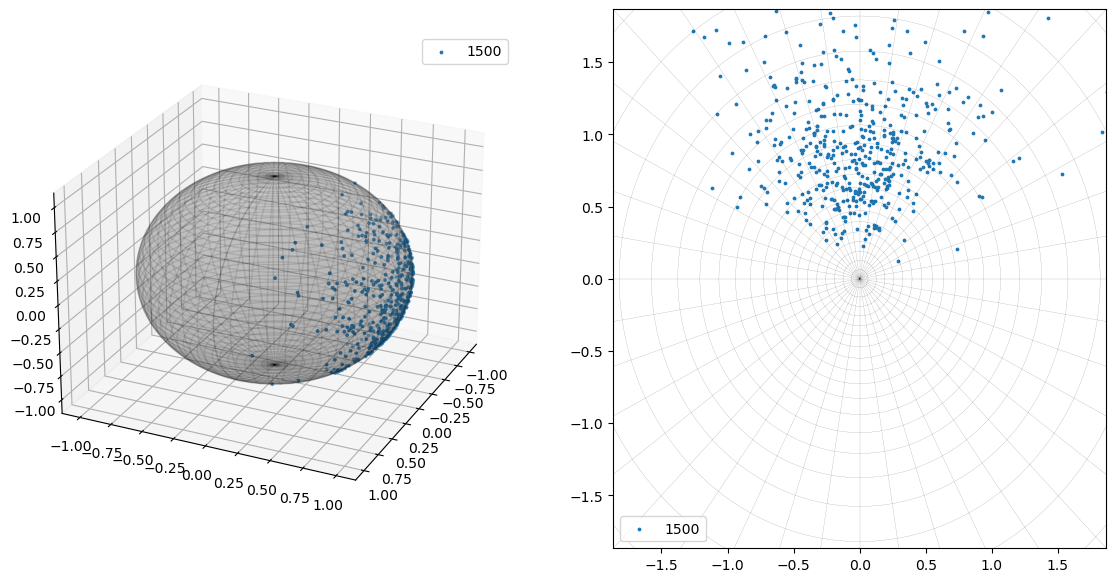

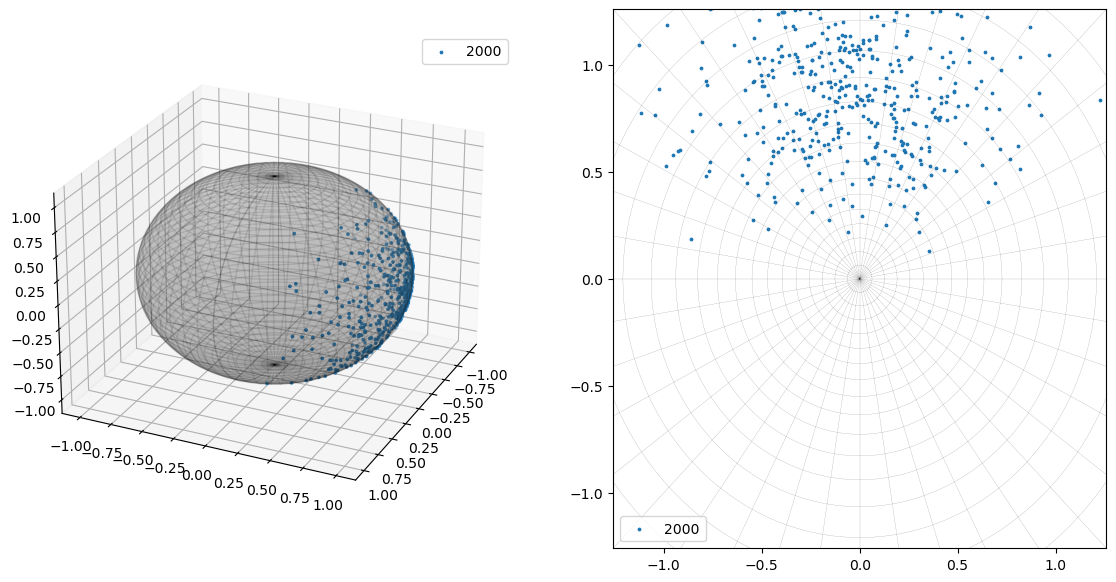

In [16]:
for epoch, m_snapshot, kappa_snapshot in s:
    ps_snapshot = power_spherical_utils.PowerSpherical(m_snapshot, kappa_snapshot)
    samples = ps_snapshot.sample((500,))  
    cart_samples = samples.cpu().numpy()
    plot_utils.plot_all([cart_samples], [f"{epoch}"], view_init=(25, 25))

In [17]:
# for epoch, m_snapshot, kappa_snapshot in s:
#     ps_snapshot = power_spherical_utils.PowerSpherical(m_snapshot, kappa_snapshot)
#     samples = ps_snapshot.sample((500,))  
#     cart_samples = samples.cpu().numpy()
#     plot_utils.scatter_mollweide(cart_samples, target)

In [18]:
# n_points = 500

# theta = np.linspace(0, 2 * np.pi, n_points)  
# phi = np.linspace(0, np.pi, n_points)       
# theta_grid, phi_grid = np.meshgrid(theta, phi)
# tp = np.vstack([theta_grid.ravel(), phi_grid.ravel()]).T

# mu = torch.tensor([0, 1, 0], dtype=torch.float, device=device)
# kappa = torch.tensor(10, device=device)
# ps = power_spherical_utils.PowerSpherical(mu, kappa)
# V = lambda x: -ps.log_prob(x)
# target = lambda x: np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())
# maxi = target(plot_utils.spherical_to_cartesian(tp)).max()

# fig, axes = plt.subplots(1, 4, figsize=(20, 15), subplot_kw={'projection': "mollweide"})

# epochs = [0, 500, 1000, 2000]
# for idx, epoch in enumerate(epochs):
#     mu_i = torch.tensor(Lm[epoch])
#     kappa_i = torch.tensor(Lk[epoch])
#     ps = power_spherical_utils.PowerSpherical(mu_i, kappa_i)
    
#     V = lambda x: -ps.log_prob(x)
#     target = lambda x: np.exp(-V(torch.tensor(x, dtype=torch.float)).cpu().numpy())
    
#     plot_utils.projection_mollweide(target, axes[idx], maxi)  

# plt.show()

# Mixture of vMF target + NF

In [19]:
# d_func = s3w.s3wd 
# d_args = {'p': 2, 'n_projs': 1000, 'device': device}
d_func = ssw.sswd 
d_args = {'p': 2, 'num_projections': 1000, 'device': device}

In [21]:
mus = torch.tensor([[1.5, 0.7 + np.pi/2], [1, -1 + np.pi/2], [5, 0.6 + np.pi/2], [4, -0.7 + np.pi/2]], device=device)
target_mus = misc_utils.spherical_to_euclidean_torch(mus)

def target_density(x):
    x = x.to(target_mus.device)
    m = torch.matmul(x, target_mus.T)
    return torch.sum(torch.exp(10 * m), dim=-1)

In [ ]:
V = lambda x: -torch.log(target_density(x))
target = lambda x: np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

model, snapshots = vmf_mixture.run_exp(
    n_epochs=10001, 
    V=V, 
    d_func=d_func, 
    d_args=d_args,     
    lr=1e-3, 
    n_particles=100, 
    dt_mcmc=1e-1, 
    snapshot_t=[0, 1000, 2000, 5000, 10000]  
)


In [23]:
# torch.save(model, './model.pth')
# torch.save(snapshots, './snapshots.pth')

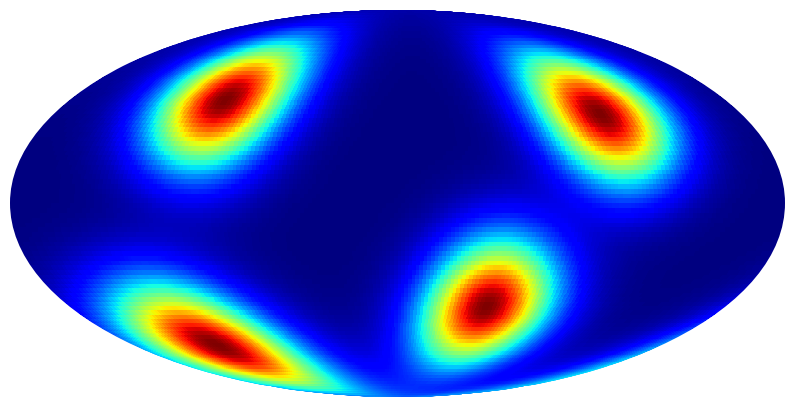

In [24]:
target_mu = misc_utils.spherical_to_euclidean(np.array([
    [1.5, 0.7 + np.pi / 2],
    [1., -1. + np.pi / 2],
    [5., 0.6 + np.pi / 2],  # 0.5 -> 5.!
    [4., -0.7 + np.pi / 2]
]))

def s2_target(x):
    xe = np.dot(x, target_mu.T)
    return np.sum(np.exp(10 * xe), axis=1)

fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(target, ax)
plt.show()

In [ ]:
device='cpu'

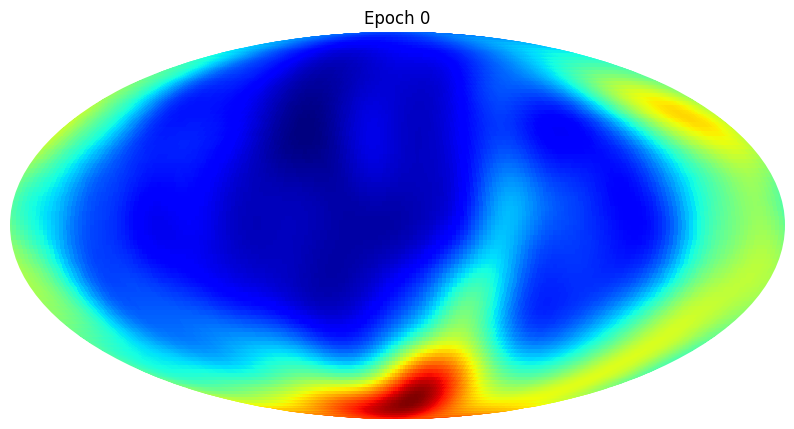

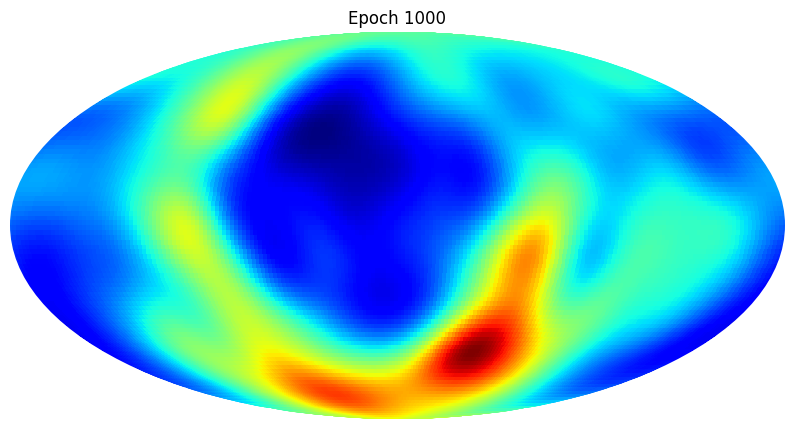

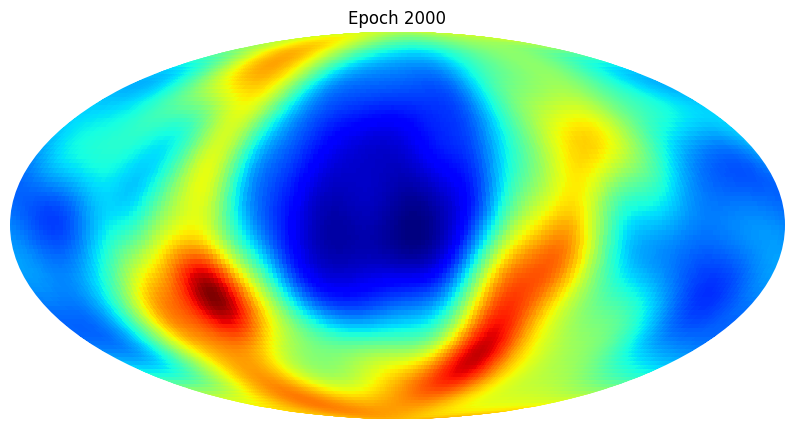

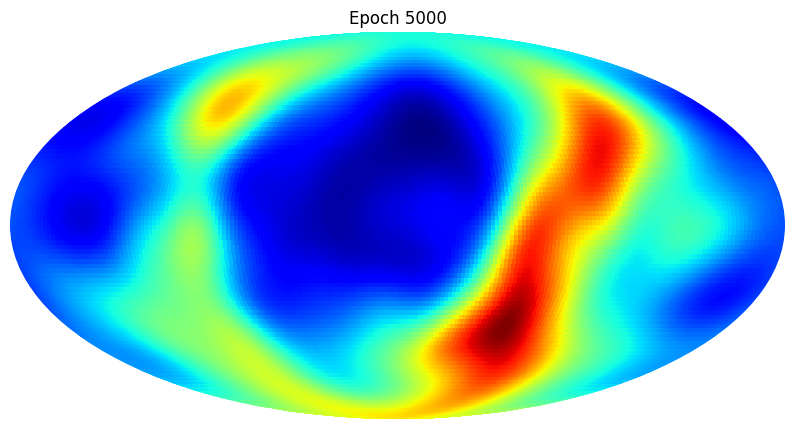

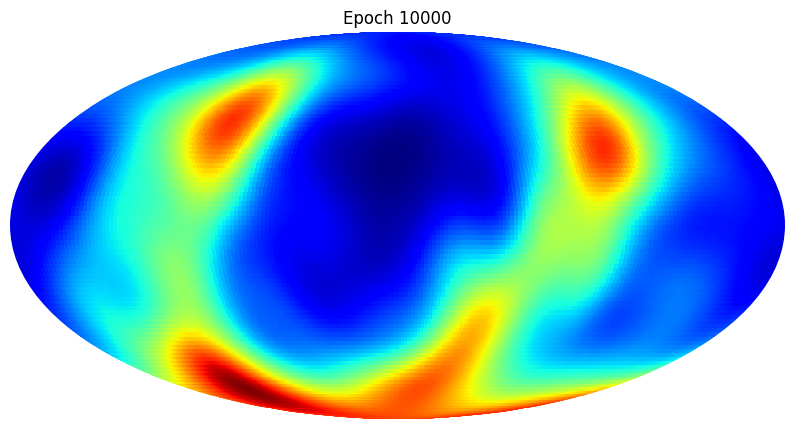

In [ ]:
for epoch, snapshot in snapshots:
    noise = F.normalize(torch.randn((1000, 3), device=device), p=2, dim=-1)

    snapshot = snapshot.to(device)

    z0, _ = snapshot(noise)
    samples_np = z0[-1].detach().cpu().numpy()
    kernel = gaussian_kde(samples_np.T)
    
    def density_estimation(x): return kernel(x.T)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': "mollweide"})
    plot_utils.projection_mollweide(density_estimation, ax)
    plt.title(f"Epoch {epoch}")
    plt.show()

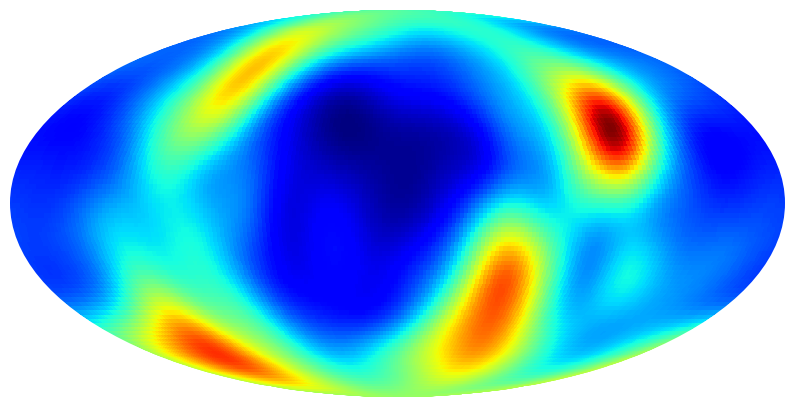

In [ ]:
noise = F.normalize(torch.randn((1000,3), device=device), p=2, dim=-1)
z0, _ = snapshots[-1][1](noise)

kernel = gaussian_kde(z0[-1].T.detach().cpu())


fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: kernel.pdf(x.T), ax)
plt.show()